In [1]:
%matplotlib inline

In [2]:
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib
import numpy as np
from pathlib import Path
from skimage.io import imread
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder, DatasetFolder
import torchvision.utils as vutils

## Dataset and Data Loader

In [3]:
def show_batch(dl, limit=64):
    """Display a batch of images.
    
    Parameters
    -----------
    dl: DataLoader
    limit: int
        Max # of images to display (since we usually don't need to see all 128
        images in the batch).
    """
    batch = next(iter(dl))
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.imshow(np.transpose(vutils.make_grid(batch[0][:limit], normalize=True, 
                                             nrow=8), (1, 2, 0)))
    plt.axis('off')
    plt.show()

In [42]:
ngpu = 1
workers = 4 # testing, example used 2
img_size = 64
input_c = 100
bs = 64
root = 'sketch_data/photo/tx_000100000000'
device = torch.device('cuda:0' if torch.cuda.is_available() and ngpu > 0 
                      else 'cpu')

In [43]:
tfms = transforms.Compose([transforms.Resize(img_size),
                           transforms.ToTensor(),
                           transforms.Normalize([.5, .5, .5], [.5, .5, .5])])

photo_ds = ImageFolder(root, transform=tfms)
photo_dl = DataLoader(photo_ds, batch_size=bs, shuffle=True, 
                      num_workers=workers)

In [44]:
batch = next(iter(photo_dl))
batch[0].shape, batch[1].shape

(torch.Size([64, 3, 64, 64]), torch.Size([64]))

In [ ]:
# For testing, try folder that contains: camel, giraffe, horse, zebra
root_small = root + '/tmp'
small_bs = 64

small_ds = ImageFolder(root_small, transform=tfms)
small_dl = DataLoader(small_ds, batch_size=small_bs, shuffle=True, 
                      num_workers=workers)

In [ ]:
show_batch(small_dl)

## Models

In [11]:
def conv(strided, c_in, c_out, f, stride, pad, bias=False, bn=True):
    """Create deconv block consisting of a backward strided convolution 
    optionally followed by a batch norm layer.
    """
    if strided:
        conv_ = nn.ConvTranspose2d(c_in, c_out, f, stride, pad, bias=bias)
    else:
        conv_ = nn.Conv2d(c_in, c_out, f, stride, pad, bias=bias)
    conv_.weight.data.normal_(0.0, 0.02)
    layers = [conv_]
    if bn:
        bn_ = nn.BatchNorm2d(c_out)
        bn_.weight.data.normal_(1.0, 0.02)
        bn_.bias.data.zero_()
        layers.append(bn_)
    return nn.Sequential(*layers)

In [12]:
class Generator(nn.Module):
    
    def __init__(self, input_c=100, final_c=64):
        super().__init__()
        # 100 x 1 x 1 -> 512 x 4 x 4
        self.deconv1 = conv(True, input_c, final_c*8, f=4, stride=1, pad=0)
        # 512 x 4 x 4 -> 256 x 8 x 8
        self.deconv2 = conv(True, final_c*8, final_c*4, 4, 2, 1)
        # 256 x 8 x 8 -> 128 x 16 x 16
        self.deconv3 = conv(True, final_c*4, final_c*2, 4, 2, 1)
        # 128 x 16 x 16 -> 64 x 32 x 32
        self.deconv4 = conv(True, final_c*2, final_c, 4, 2, 1)
        # 64 x 32 x 32 -> 3 x 64 x 64
        self.deconv5 = conv(True, final_c, 3, 4, 2, 1, bn=False)
        
    def forward(self, x):
        x = F.relu(self.deconv1(x), True)
        x = F.relu(self.deconv2(x), True)
        x = F.relu(self.deconv3(x), True)
        x = F.relu(self.deconv4(x), True)
        x = torch.tanh(self.deconv5(x))
        return x

    def dims(self):
        """Get shape of each layer's weights."""
        return [p.shape for p in self.parameters()]
    
    def trainable(self):
        """Check which layers are trainable."""
        return [p.requires_grad for p in self.parameters()]
    
    def layer_stats(self):
        """Check mean and standard deviation of each layer's weights."""
        return [(round(p.data.mean().item(), 3), 
                 round(p.data.std().item(), 3))
                 for p in self.parameters()]

In [13]:
class Discriminator(nn.Module):
    
    def __init__(self, dim_1=64, leak=.02):
        """
        Parameters
        -----------
        dim_1: int
            # of filters in first conv layer.
        leak: float
            Slope of leaky relu where x < 0.
        """
        super().__init__()
        self.leak = leak
        
        # 3 x 64 x 64 -> 64 x 32 x 32
        self.conv1 = conv(False, 3, dim_1, f=4, stride=2, pad=1, bn=False)
        # 64 x 32 x 32 -> 128 x 16 x 16
        self.conv2 = conv(False, dim_1, dim_1*2, 4, 2, 1)
        # 128 x 16 x 16 -> 256 x 8 x 8
        self.conv3 = conv(False, dim_1*2, dim_1*4, 4, 2, 1)
        # 256 x 8 x 8 -> 512 x 4 x 4
        self.conv4 = conv(False, dim_1*4, dim_1*8, 4, 2, 1)
        # 512 x 4 x 4 -> 1 x 1 x 1
        self.conv5 = conv(False, dim_1*8, 1, 4, 1, 0, bn=False)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), self.leak, True)
        x = F.leaky_relu(self.conv2(x), self.leak, True)
        x = F.leaky_relu(self.conv3(x), self.leak, True)
        x = F.leaky_relu(self.conv4(x), self.leak, True)
        x = torch.sigmoid(self.conv5(x))
        return x.squeeze()
    
    def dims(self):
        """Get shape of each layer's weights."""
        return [p.shape for p in self.parameters()]
    
    def trainable(self):
        """Check which layers are trainable."""
        return [p.requires_grad for p in self.parameters()]
    
    def layer_stats(self):
        """Check mean and standard deviation of each layer's weights."""
        return [(round(p.data.mean().item(), 3), 
                 round(p.data.std().item(), 3))
                 for p in self.parameters()]

In [14]:
# g = Generator().to(device)

In [15]:
# y_tmp = g(batch[0])
# y_tmp.shape

In [16]:
# d = Discriminator().to(device)

In [17]:
# d(y_tmp).shape

## Training

In [22]:
def train(epochs, dl, lr=2e-4, b1=.5, sample_freq=10, d=None, g=None):
    """Train generator and discriminator with Adam.
    
    Parameters
    -----------
    D: nn.Module
        Discriminator
    G: nn.Module
        Generator (binary classifier, 1 for real, 0 for fake).
    dl: DataLoader
    lr: float
        Learning rate. Paper recommends .0002.
    beta1: float
        Hyperparameter for Adam. Paper recommends 0.5.
    sample_freq: int
        Save sample images from generator every n epochs (default 10).
    """
    if not (d or g):
        g = Generator().to(device)
        d = Discriminator().to(device)
        g.train()
        d.train()
    
    # Define loss and optimizers.
    criterion = nn.BCELoss()
    d_optim = torch.optim.Adam(d.parameters(), lr=lr, betas=(b1, .999))
    g_optim = torch.optim.Adam(g.parameters(), lr=lr, betas=(b1, .999))
    
    # Noise used for sample images, not training.
    fixed_noise = torch.randn(dl.batch_size, 100, 1, 1, device=device)
    real_label = 1
    fake_label = 0
    
    # Store stats to return at end.
    d_real_losses = []
    d_fake_losses = []
    d_real_avg = []
    d_fake_avg = []
    g_losses = []
    samples = []
    
    # Train D and G.
    for epoch in range(epochs):
        for i, (x, y) in enumerate(dl):
            x = x.to(device)
            bs_curr = x.shape[0]
            real_labels = torch.ones(bs_curr, device=device)
            fake_labels = torch.zeros(bs_curr, device=device)
            noise = torch.randn(bs_curr, 100, 1, 1, device=device)
            
            ##################################################################
            # Train discriminator. Detach G output for speed.
            ##################################################################
            d_optim.zero_grad()
            fake = g(noise)
            y_hat_fake = d(fake.detach())
            y_hat_real = d(x)
            
            # Compute losses.
            d_loss_fake = criterion(y_hat_fake, fake_labels)
            d_loss_real = criterion(y_hat_real, real_labels)
            d_loss = d_loss_real + d_loss_fake
            
            # Update stats.
            fake_avg = y_hat_fake.mean().item()
            real_avg = y_hat_real.mean().item()
            d_fake_avg.append(fake_avg)
            d_real_avg.append(real_avg)
            d_fake_losses.append(d_loss_fake)
            d_real_losses.append(d_loss_real)
            
            # Backpropagation.
            d_loss.backward()
            d_optim.step()
            
            ##################################################################
            # Train generator. Use true_labels because we want to fool D.
            # G's weights are the same so no need to re-generate fake 
            # examples. D was updated so compute loss again. 
            ##################################################################
            g_optim.zero_grad()
            g_loss = criterion(d(fake), real_labels)
            g_losses.append(g_loss)
            g_loss.backward()
            g_optim.step()
        
        # Print losses.
        print(f'Epoch [{epoch+1}/{epochs}] \nBatch {i+1} Metrics:')
        print(f'D loss (real): {d_loss_real:.4f}\t', end='')
        print(f'D loss (fake): {d_loss_fake:.4f}')
        print(f'G loss: {g_loss:.4f}\n')
            
        # Save weights at end of epoch.
#         states = dict(g=g.state_dict(), 
#                       d=d.state_dict(),
#                       g_optimizer=g_optim.state_dict(),
#                       d_optimizer=d_optim.state_dict(),
#                       epoch=epoch)
#         torch.save(states, 'weights/model.pth')

        # Generate sample from fixed noise at end of every fifth epoch.
        if epoch % sample_freq == 0:
            with torch.no_grad():
                vutils.save_image(fake.detach(), 
                                  f'samples/fake_epoch_{epoch}.png',
                                  normalize=True)
#                 fake = g(fixed_noise).detach().cpu()
#                 samples.append(fake)
        
    return samples, dict(d_real_losses=d_real_losses, 
                         d_fake_losses=d_fake_losses,
                         g_losses=g_losses,
                         d_real_avg=d_real_avg,
                         d_fake_avg=d_fake_avg)

In [23]:
epochs = 2000
samples, output = train(epochs, small_dl, sample_freq=100)

Epoch [1/2000] 
Batch 7 Metrics:
D loss (real): 0.2408	D loss (fake): 0.4929
G loss: 7.9145

Epoch [2/2000] 
Batch 7 Metrics:
D loss (real): 0.2252	D loss (fake): 0.2596
G loss: 9.6771

Epoch [3/2000] 
Batch 7 Metrics:
D loss (real): 0.2964	D loss (fake): 0.0116
G loss: 7.3147

Epoch [4/2000] 
Batch 7 Metrics:
D loss (real): 0.0308	D loss (fake): 0.3381
G loss: 15.9397

Epoch [5/2000] 
Batch 7 Metrics:
D loss (real): 0.0158	D loss (fake): 0.3052
G loss: 15.8276

Epoch [6/2000] 
Batch 7 Metrics:
D loss (real): 0.1915	D loss (fake): 0.0427
G loss: 7.6598

Epoch [7/2000] 
Batch 7 Metrics:
D loss (real): 0.1606	D loss (fake): 0.0000
G loss: 29.1521

Epoch [8/2000] 
Batch 7 Metrics:
D loss (real): 0.0053	D loss (fake): 0.0018
G loss: 6.7723

Epoch [9/2000] 
Batch 7 Metrics:
D loss (real): 0.0050	D loss (fake): 0.0086
G loss: 5.9417

Epoch [10/2000] 
Batch 7 Metrics:
D loss (real): 0.0059	D loss (fake): 0.0006
G loss: 8.0268

Epoch [11/2000] 
Batch 7 Metrics:
D loss (real): 0.2013	D loss (fa

Epoch [89/2000] 
Batch 7 Metrics:
D loss (real): 0.0527	D loss (fake): 0.0402
G loss: 5.6994

Epoch [90/2000] 
Batch 7 Metrics:
D loss (real): 0.0510	D loss (fake): 0.0291
G loss: 4.7232

Epoch [91/2000] 
Batch 7 Metrics:
D loss (real): 0.1268	D loss (fake): 0.0421
G loss: 4.4414

Epoch [92/2000] 
Batch 7 Metrics:
D loss (real): 0.0595	D loss (fake): 0.0652
G loss: 5.4756

Epoch [93/2000] 
Batch 7 Metrics:
D loss (real): 0.4496	D loss (fake): 0.0146
G loss: 1.6899

Epoch [94/2000] 
Batch 7 Metrics:
D loss (real): 0.2433	D loss (fake): 0.0197
G loss: 3.6966

Epoch [95/2000] 
Batch 7 Metrics:
D loss (real): 0.1054	D loss (fake): 0.0207
G loss: 5.1349

Epoch [96/2000] 
Batch 7 Metrics:
D loss (real): 0.2233	D loss (fake): 0.0282
G loss: 3.9006

Epoch [97/2000] 
Batch 7 Metrics:
D loss (real): 0.0094	D loss (fake): 0.2678
G loss: 8.8375

Epoch [98/2000] 
Batch 7 Metrics:
D loss (real): 0.0573	D loss (fake): 0.1496
G loss: 5.8329

Epoch [99/2000] 
Batch 7 Metrics:
D loss (real): 0.0212	D lo

Epoch [176/2000] 
Batch 7 Metrics:
D loss (real): 0.0187	D loss (fake): 0.0152
G loss: 5.8974

Epoch [177/2000] 
Batch 7 Metrics:
D loss (real): 0.0376	D loss (fake): 0.0039
G loss: 5.8012

Epoch [178/2000] 
Batch 7 Metrics:
D loss (real): 0.0669	D loss (fake): 0.0322
G loss: 4.9102

Epoch [179/2000] 
Batch 7 Metrics:
D loss (real): 0.0516	D loss (fake): 0.0056
G loss: 5.6902

Epoch [180/2000] 
Batch 7 Metrics:
D loss (real): 0.0146	D loss (fake): 0.0204
G loss: 5.8966

Epoch [181/2000] 
Batch 7 Metrics:
D loss (real): 0.0850	D loss (fake): 0.0191
G loss: 3.5287

Epoch [182/2000] 
Batch 7 Metrics:
D loss (real): 0.0640	D loss (fake): 0.0076
G loss: 4.6905

Epoch [183/2000] 
Batch 7 Metrics:
D loss (real): 0.0253	D loss (fake): 0.0088
G loss: 5.6516

Epoch [184/2000] 
Batch 7 Metrics:
D loss (real): 0.0223	D loss (fake): 0.0188
G loss: 6.4555

Epoch [185/2000] 
Batch 7 Metrics:
D loss (real): 0.0166	D loss (fake): 0.0127
G loss: 6.5220

Epoch [186/2000] 
Batch 7 Metrics:
D loss (real): 

Epoch [263/2000] 
Batch 7 Metrics:
D loss (real): 0.0148	D loss (fake): 0.0164
G loss: 6.5821

Epoch [264/2000] 
Batch 7 Metrics:
D loss (real): 0.0058	D loss (fake): 0.0337
G loss: 7.4405

Epoch [265/2000] 
Batch 7 Metrics:
D loss (real): 0.0207	D loss (fake): 0.0065
G loss: 5.6155

Epoch [266/2000] 
Batch 7 Metrics:
D loss (real): 0.0086	D loss (fake): 0.0265
G loss: 6.5037

Epoch [267/2000] 
Batch 7 Metrics:
D loss (real): 0.0207	D loss (fake): 0.0122
G loss: 5.8487

Epoch [268/2000] 
Batch 7 Metrics:
D loss (real): 0.0448	D loss (fake): 0.0086
G loss: 5.3218

Epoch [269/2000] 
Batch 7 Metrics:
D loss (real): 0.0214	D loss (fake): 0.0061
G loss: 6.5601

Epoch [270/2000] 
Batch 7 Metrics:
D loss (real): 0.0116	D loss (fake): 0.0135
G loss: 6.8054

Epoch [271/2000] 
Batch 7 Metrics:
D loss (real): 0.0199	D loss (fake): 0.0064
G loss: 6.6214

Epoch [272/2000] 
Batch 7 Metrics:
D loss (real): 0.0141	D loss (fake): 0.0182
G loss: 7.4507

Epoch [273/2000] 
Batch 7 Metrics:
D loss (real): 

Epoch [350/2000] 
Batch 7 Metrics:
D loss (real): 0.0102	D loss (fake): 0.0046
G loss: 6.6687

Epoch [351/2000] 
Batch 7 Metrics:
D loss (real): 0.0065	D loss (fake): 0.0074
G loss: 7.6252

Epoch [352/2000] 
Batch 7 Metrics:
D loss (real): 0.0046	D loss (fake): 0.0033
G loss: 7.2822

Epoch [353/2000] 
Batch 7 Metrics:
D loss (real): 0.0196	D loss (fake): 0.0036
G loss: 6.4635

Epoch [354/2000] 
Batch 7 Metrics:
D loss (real): 0.0150	D loss (fake): 0.0053
G loss: 6.3369

Epoch [355/2000] 
Batch 7 Metrics:
D loss (real): 0.0289	D loss (fake): 0.0025
G loss: 6.3717

Epoch [356/2000] 
Batch 7 Metrics:
D loss (real): 0.0039	D loss (fake): 0.0061
G loss: 7.9110

Epoch [357/2000] 
Batch 7 Metrics:
D loss (real): 0.0143	D loss (fake): 0.0120
G loss: 8.4919

Epoch [358/2000] 
Batch 7 Metrics:
D loss (real): 0.0076	D loss (fake): 0.0010
G loss: 8.2758

Epoch [359/2000] 
Batch 7 Metrics:
D loss (real): 0.0023	D loss (fake): 0.0036
G loss: 7.9797

Epoch [360/2000] 
Batch 7 Metrics:
D loss (real): 

Epoch [436/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.7364

Epoch [437/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.8783

Epoch [438/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 53.9620

Epoch [439/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.6385

Epoch [440/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 55.3057

Epoch [441/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 55.1227

Epoch [442/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.8455

Epoch [443/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.7798

Epoch [444/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.8027

Epoch [445/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 55.2314

Epoch [446/2000] 
Batch 7 Metrics:
D los

Epoch [522/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 55.0051

Epoch [523/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.5727

Epoch [524/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.4193

Epoch [525/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.6607

Epoch [526/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.2572

Epoch [527/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.6008

Epoch [528/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.8069

Epoch [529/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 55.0668

Epoch [530/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 55.0045

Epoch [531/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 55.3395

Epoch [532/2000] 
Batch 7 Metrics:
D los

Epoch [608/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 55.1035

Epoch [609/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.9850

Epoch [610/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 55.2317

Epoch [611/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.4735

Epoch [612/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.7401

Epoch [613/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.5326

Epoch [614/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.3508

Epoch [615/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 55.1185

Epoch [616/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.7111

Epoch [617/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.3335

Epoch [618/2000] 
Batch 7 Metrics:
D los

Epoch [694/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.4456

Epoch [695/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.3949

Epoch [696/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.3535

Epoch [697/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.8803

Epoch [698/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 55.0098

Epoch [699/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 55.2148

Epoch [700/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 55.1456

Epoch [701/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.8217

Epoch [702/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 55.3082

Epoch [703/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.9990

Epoch [704/2000] 
Batch 7 Metrics:
D los

Epoch [780/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.6489

Epoch [781/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.8886

Epoch [782/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.7041

Epoch [783/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.7687

Epoch [784/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 55.3170

Epoch [785/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.3509

Epoch [786/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.5786

Epoch [787/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.5204

Epoch [788/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.8615

Epoch [789/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.5618

Epoch [790/2000] 
Batch 7 Metrics:
D los

Epoch [866/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.9716

Epoch [867/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.6716

Epoch [868/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.1294

Epoch [869/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.0906

Epoch [870/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.9739

Epoch [871/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.8410

Epoch [872/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.8948

Epoch [873/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.4432

Epoch [874/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.3340

Epoch [875/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.0156

Epoch [876/2000] 
Batch 7 Metrics:
D los

Epoch [952/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.8395

Epoch [953/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.7751

Epoch [954/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.7068

Epoch [955/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.7673

Epoch [956/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 55.0884

Epoch [957/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.9640

Epoch [958/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 55.0228

Epoch [959/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.6269

Epoch [960/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.4052

Epoch [961/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.9111

Epoch [962/2000] 
Batch 7 Metrics:
D los

Epoch [1037/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.1740

Epoch [1038/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.5126

Epoch [1039/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.5952

Epoch [1040/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 55.0442

Epoch [1041/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.5311

Epoch [1042/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 55.0335

Epoch [1043/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 55.1697

Epoch [1044/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.2216

Epoch [1045/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.6237

Epoch [1046/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.4399

Epoch [1047/2000] 
Batch 7 Met

Epoch [1122/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.2645

Epoch [1123/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.8645

Epoch [1124/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.8050

Epoch [1125/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.8665

Epoch [1126/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 55.1622

Epoch [1127/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 55.0485

Epoch [1128/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.7256

Epoch [1129/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.3506

Epoch [1130/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.0581

Epoch [1131/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.4709

Epoch [1132/2000] 
Batch 7 Met

Epoch [1207/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.5222

Epoch [1208/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.6428

Epoch [1209/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 55.0054

Epoch [1210/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.7203

Epoch [1211/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 55.0051

Epoch [1212/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.5836

Epoch [1213/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.5505

Epoch [1214/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.8211

Epoch [1215/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 55.1458

Epoch [1216/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.2841

Epoch [1217/2000] 
Batch 7 Met

Epoch [1292/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.7802

Epoch [1293/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.0855

Epoch [1294/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.8992

Epoch [1295/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.2126

Epoch [1296/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.5051

Epoch [1297/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.6153

Epoch [1298/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.9294

Epoch [1299/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 55.2696

Epoch [1300/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 55.0452

Epoch [1301/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.6646

Epoch [1302/2000] 
Batch 7 Met

Epoch [1377/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.8059

Epoch [1378/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.2218

Epoch [1379/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.7761

Epoch [1380/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 55.0259

Epoch [1381/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 55.1942

Epoch [1382/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 55.1717

Epoch [1383/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.5084

Epoch [1384/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 55.2862

Epoch [1385/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.3321

Epoch [1386/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.8734

Epoch [1387/2000] 
Batch 7 Met

Epoch [1462/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 53.5523

Epoch [1463/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.1166

Epoch [1464/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.2673

Epoch [1465/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.8954

Epoch [1466/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.5695

Epoch [1467/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.2800

Epoch [1468/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.7281

Epoch [1469/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.4465

Epoch [1470/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.3902

Epoch [1471/2000] 
Batch 7 Metrics:
D loss (real): 0.0000	D loss (fake): 0.0000
G loss: 54.8428

Epoch [1472/2000] 
Batch 7 Met

Epoch [1547/2000] 
Batch 7 Metrics:
D loss (real): 0.4269	D loss (fake): 0.8799
G loss: 2.0976

Epoch [1548/2000] 
Batch 7 Metrics:
D loss (real): 0.6235	D loss (fake): 0.3203
G loss: 1.0078

Epoch [1549/2000] 
Batch 7 Metrics:
D loss (real): 0.3399	D loss (fake): 0.6913
G loss: 2.4810

Epoch [1550/2000] 
Batch 7 Metrics:
D loss (real): 0.7817	D loss (fake): 0.6069
G loss: 1.4143

Epoch [1551/2000] 
Batch 7 Metrics:
D loss (real): 0.3914	D loss (fake): 0.4372
G loss: 3.0228

Epoch [1552/2000] 
Batch 7 Metrics:
D loss (real): 0.4798	D loss (fake): 0.2430
G loss: 2.2993

Epoch [1553/2000] 
Batch 7 Metrics:
D loss (real): 0.4668	D loss (fake): 0.9577
G loss: 2.3728

Epoch [1554/2000] 
Batch 7 Metrics:
D loss (real): 0.3925	D loss (fake): 0.6052
G loss: 4.3307

Epoch [1555/2000] 
Batch 7 Metrics:
D loss (real): 0.3436	D loss (fake): 1.0594
G loss: 2.7708

Epoch [1556/2000] 
Batch 7 Metrics:
D loss (real): 0.1892	D loss (fake): 0.4300
G loss: 4.3861

Epoch [1557/2000] 
Batch 7 Metrics:
D lo

Epoch [1633/2000] 
Batch 7 Metrics:
D loss (real): 0.1102	D loss (fake): 0.0193
G loss: 5.5280

Epoch [1634/2000] 
Batch 7 Metrics:
D loss (real): 0.1930	D loss (fake): 0.0272
G loss: 5.0016

Epoch [1635/2000] 
Batch 7 Metrics:
D loss (real): 0.1161	D loss (fake): 0.0687
G loss: 5.7275

Epoch [1636/2000] 
Batch 7 Metrics:
D loss (real): 0.0603	D loss (fake): 0.0800
G loss: 6.9013

Epoch [1637/2000] 
Batch 7 Metrics:
D loss (real): 0.2788	D loss (fake): 0.0873
G loss: 5.1641

Epoch [1638/2000] 
Batch 7 Metrics:
D loss (real): 0.0636	D loss (fake): 0.0160
G loss: 6.2648

Epoch [1639/2000] 
Batch 7 Metrics:
D loss (real): 0.0469	D loss (fake): 0.0640
G loss: 5.3420

Epoch [1640/2000] 
Batch 7 Metrics:
D loss (real): 0.0371	D loss (fake): 0.0696
G loss: 5.8200

Epoch [1641/2000] 
Batch 7 Metrics:
D loss (real): 0.0399	D loss (fake): 0.0910
G loss: 6.7683

Epoch [1642/2000] 
Batch 7 Metrics:
D loss (real): 0.0648	D loss (fake): 0.0527
G loss: 4.9245

Epoch [1643/2000] 
Batch 7 Metrics:
D lo

Epoch [1719/2000] 
Batch 7 Metrics:
D loss (real): 0.0496	D loss (fake): 0.1191
G loss: 10.3694

Epoch [1720/2000] 
Batch 7 Metrics:
D loss (real): 0.0528	D loss (fake): 0.0552
G loss: 5.9013

Epoch [1721/2000] 
Batch 7 Metrics:
D loss (real): 0.0029	D loss (fake): 0.0933
G loss: 8.6532

Epoch [1722/2000] 
Batch 7 Metrics:
D loss (real): 0.0338	D loss (fake): 0.0787
G loss: 7.7580

Epoch [1723/2000] 
Batch 7 Metrics:
D loss (real): 0.0278	D loss (fake): 0.0347
G loss: 6.5436

Epoch [1724/2000] 
Batch 7 Metrics:
D loss (real): 0.0426	D loss (fake): 0.0181
G loss: 6.2424

Epoch [1725/2000] 
Batch 7 Metrics:
D loss (real): 0.0514	D loss (fake): 0.0618
G loss: 9.6825

Epoch [1726/2000] 
Batch 7 Metrics:
D loss (real): 0.0533	D loss (fake): 0.1486
G loss: 10.0582

Epoch [1727/2000] 
Batch 7 Metrics:
D loss (real): 0.0087	D loss (fake): 0.0193
G loss: 8.7275

Epoch [1728/2000] 
Batch 7 Metrics:
D loss (real): 0.0245	D loss (fake): 0.0531
G loss: 9.6640

Epoch [1729/2000] 
Batch 7 Metrics:
D 

Epoch [1805/2000] 
Batch 7 Metrics:
D loss (real): 0.0277	D loss (fake): 0.0004
G loss: 8.8801

Epoch [1806/2000] 
Batch 7 Metrics:
D loss (real): 0.0050	D loss (fake): 0.0045
G loss: 9.7186

Epoch [1807/2000] 
Batch 7 Metrics:
D loss (real): 0.0272	D loss (fake): 0.0209
G loss: 10.0290

Epoch [1808/2000] 
Batch 7 Metrics:
D loss (real): 0.0009	D loss (fake): 0.0046
G loss: 7.7280

Epoch [1809/2000] 
Batch 7 Metrics:
D loss (real): 0.0057	D loss (fake): 0.0021
G loss: 7.9691

Epoch [1810/2000] 
Batch 7 Metrics:
D loss (real): 0.0116	D loss (fake): 0.0179
G loss: 10.2700

Epoch [1811/2000] 
Batch 7 Metrics:
D loss (real): 0.0207	D loss (fake): 0.0012
G loss: 7.2890

Epoch [1812/2000] 
Batch 7 Metrics:
D loss (real): 0.0151	D loss (fake): 0.0021
G loss: 7.3035

Epoch [1813/2000] 
Batch 7 Metrics:
D loss (real): 0.0025	D loss (fake): 0.0039
G loss: 7.8543

Epoch [1814/2000] 
Batch 7 Metrics:
D loss (real): 0.0113	D loss (fake): 0.0030
G loss: 7.1861

Epoch [1815/2000] 
Batch 7 Metrics:
D 

Epoch [1891/2000] 
Batch 7 Metrics:
D loss (real): 0.4817	D loss (fake): 0.0009
G loss: 21.5551

Epoch [1892/2000] 
Batch 7 Metrics:
D loss (real): 0.0072	D loss (fake): 0.0144
G loss: 9.9184

Epoch [1893/2000] 
Batch 7 Metrics:
D loss (real): 0.1265	D loss (fake): 0.0170
G loss: 7.4827

Epoch [1894/2000] 
Batch 7 Metrics:
D loss (real): 0.0012	D loss (fake): 0.0045
G loss: 8.9463

Epoch [1895/2000] 
Batch 7 Metrics:
D loss (real): 0.0051	D loss (fake): 0.0803
G loss: 14.3202

Epoch [1896/2000] 
Batch 7 Metrics:
D loss (real): 0.0032	D loss (fake): 0.0025
G loss: 9.2353

Epoch [1897/2000] 
Batch 7 Metrics:
D loss (real): 0.0112	D loss (fake): 0.0063
G loss: 7.0105

Epoch [1898/2000] 
Batch 7 Metrics:
D loss (real): 0.0156	D loss (fake): 0.0111
G loss: 6.9778

Epoch [1899/2000] 
Batch 7 Metrics:
D loss (real): 0.0106	D loss (fake): 0.0035
G loss: 10.4953

Epoch [1900/2000] 
Batch 7 Metrics:
D loss (real): 0.0080	D loss (fake): 0.0043
G loss: 7.5707

Epoch [1901/2000] 
Batch 7 Metrics:
D

Epoch [1977/2000] 
Batch 7 Metrics:
D loss (real): 0.0225	D loss (fake): 0.0055
G loss: 7.7209

Epoch [1978/2000] 
Batch 7 Metrics:
D loss (real): 0.0191	D loss (fake): 0.0037
G loss: 6.3011

Epoch [1979/2000] 
Batch 7 Metrics:
D loss (real): 0.0004	D loss (fake): 0.0004
G loss: 11.3650

Epoch [1980/2000] 
Batch 7 Metrics:
D loss (real): 0.0094	D loss (fake): 0.0019
G loss: 8.2668

Epoch [1981/2000] 
Batch 7 Metrics:
D loss (real): 0.0019	D loss (fake): 0.0059
G loss: 7.4150

Epoch [1982/2000] 
Batch 7 Metrics:
D loss (real): 0.0111	D loss (fake): 0.0027
G loss: 8.5120

Epoch [1983/2000] 
Batch 7 Metrics:
D loss (real): 0.0109	D loss (fake): 0.0042
G loss: 8.0057

Epoch [1984/2000] 
Batch 7 Metrics:
D loss (real): 0.0046	D loss (fake): 0.0053
G loss: 7.7460

Epoch [1985/2000] 
Batch 7 Metrics:
D loss (real): 0.0013	D loss (fake): 0.0028
G loss: 8.3063

Epoch [1986/2000] 
Batch 7 Metrics:
D loss (real): 0.0013	D loss (fake): 0.0011
G loss: 8.4602

Epoch [1987/2000] 
Batch 7 Metrics:
D l

## samples

In [25]:
def plot_output(output):
    """Plot losses and average predictions by mini batch."""
    # Plot losses by mini batch.
    fig, ax = plt.subplots(2, 1, figsize=(9, 6))
    ax[0].plot(output['d_real_losses'], label='D real')
    ax[0].plot(output['d_fake_losses'], label='D fake')
    ax[0].plot(output['g_losses'], label='G')
    ax[0].set_title('Loss by Mini Batch')
    ax[0].legend()
    
    # Plot soft prediction average by mini batch.
    ax[1].plot(output['d_real_avg'], label='Real examples')
    ax[1].plot(output['d_fake_avg'], label='Fake examples')
    ax[1].set_title('Average Soft Predictions (D) by Mini Batch')
    plt.tight_layout()
    plt.legend()
    plt.show()

In [26]:
# def plot_samples(samples, n=0):
#     matplotlib.rcParams['animation.writer'] = 'html'
#     fig = plt.figure(figsize=(9, 6))
#     plt.axis('off')
#     grids = [vutils.make_grid(sample, normalize=True, nrow=8)
#              for sample in samples]
#     plots = [[plt.imshow(np.transpose(grid, (1, 2, 0)), animated=True)] 
#              for grid in grids]
#     anim = animation.ArtistAnimation(fig, plots, blit=True)
#     plt.imshow(np.transpose(grids[n], (1, 2, 0)))
#     plt.show()
    
    #     HTML(data=anim.to_html5_video())
#     anim.save('samples/sample.gif', writer='avconv', fps=60)

In [27]:
def show_img(path):
    """Load image from path and display."""
    path = str(path)
    img = imread(path)
    fig = plt.figure(figsize=(9, 9))
    plt.imshow(img)
    if 'epoch' in path:
        num = path.split('.')[0].split('epoch_')[-1]
        plt.title(f'Epoch {num}')
    plt.show()

In [41]:
def show_samples(sample_dir='samples'):
    """Show samples from each """
    pattern = 'fake_epoch_'
    files = list(Path(sample_dir).glob(pattern+'*'))
    for f in sorted(files, 
                    key=lambda x: int(str(x).split('.')[-2].split('_')[-1])):
        show_img(f)

In [39]:
# plot_samples(samples, 0)

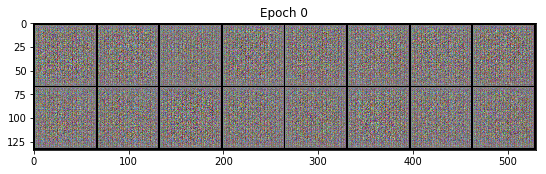

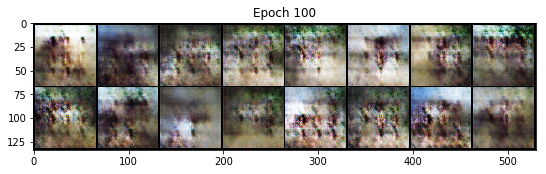

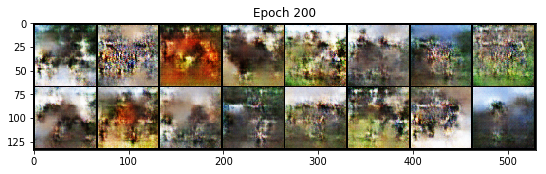

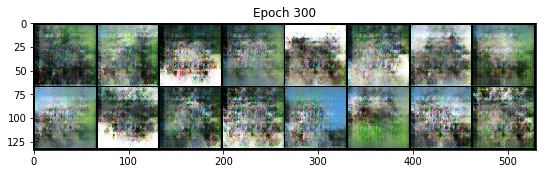

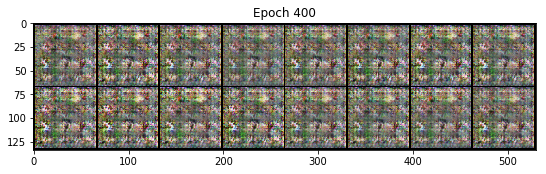

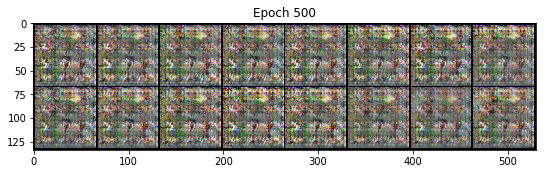

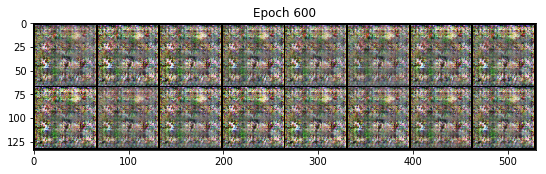

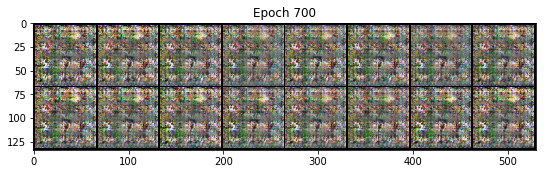

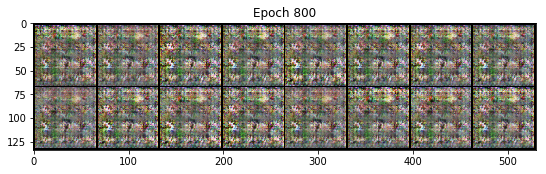

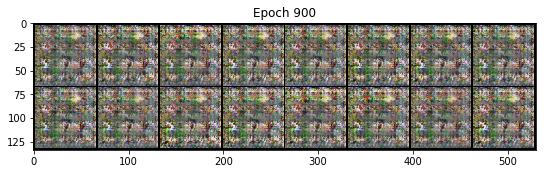

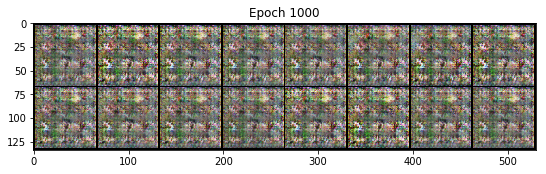

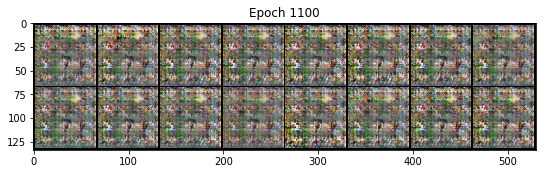

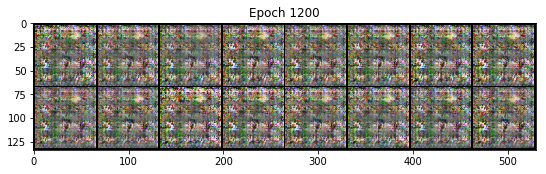

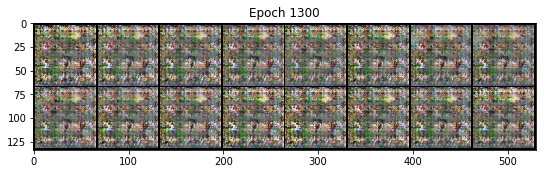

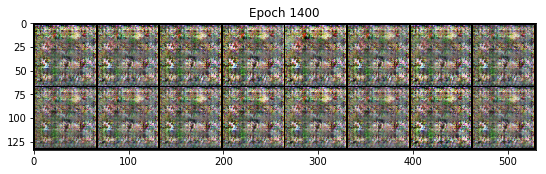

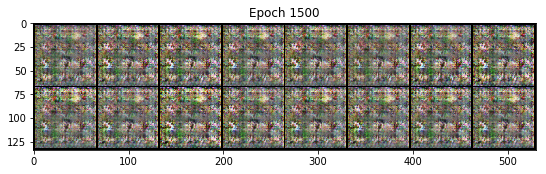

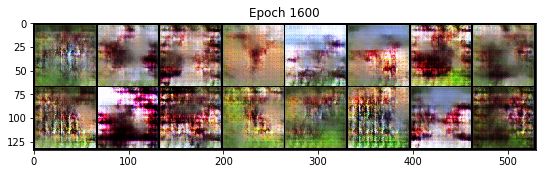

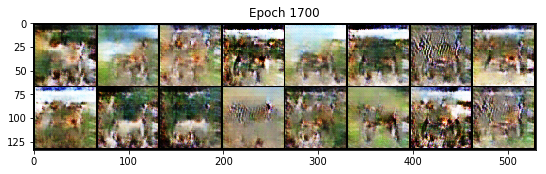

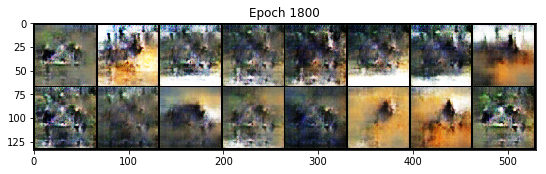

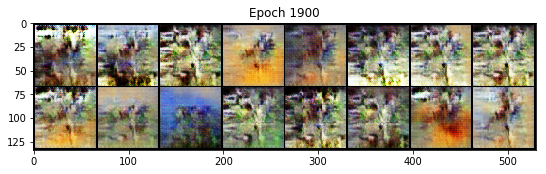

In [40]:
show_samples()

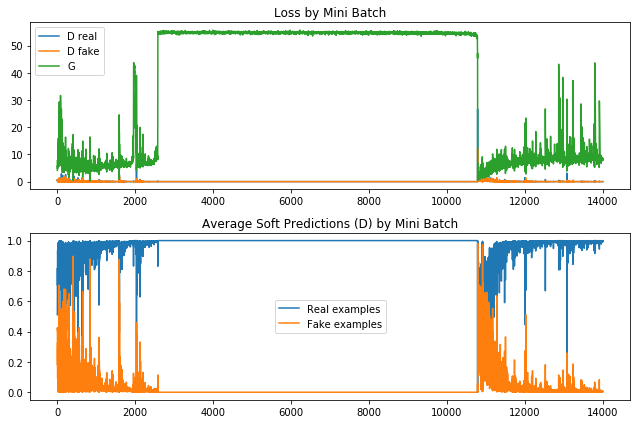

In [30]:
plot_output(output)